## Practical week 7

Initialise all necessary libraries

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Check torch version

In [2]:
print(torch.__version__)
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"GPU - {torch.cuda.get_device_name()}")

2.0.0+cu117
Cuda available: True
GPU - NVIDIA GeForce RTX 2060


Test the reLU activation function

Text(0, 0.5, 'ReLU(x)')

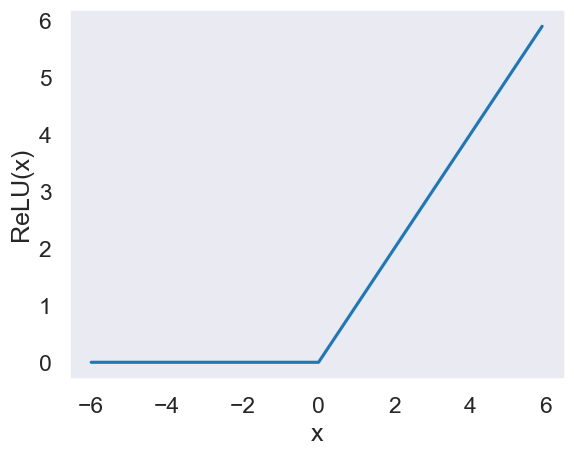

In [4]:
#Set the plot style
sns.set_context('talk')
sns.set_style('dark')
relu = torch.nn.ReLU()
input = torch.arange(-6,6,step=0.1)
output = relu(input)
sns.lineplot(x=input,y=output)
plt.xlabel('x')
plt.ylabel('ReLU(x)')

test the sigmoid activation function

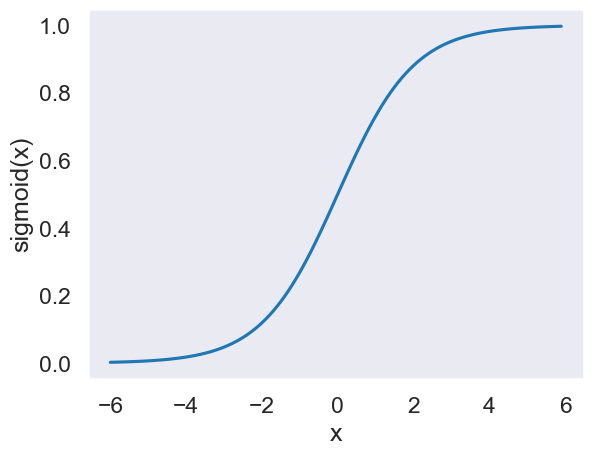

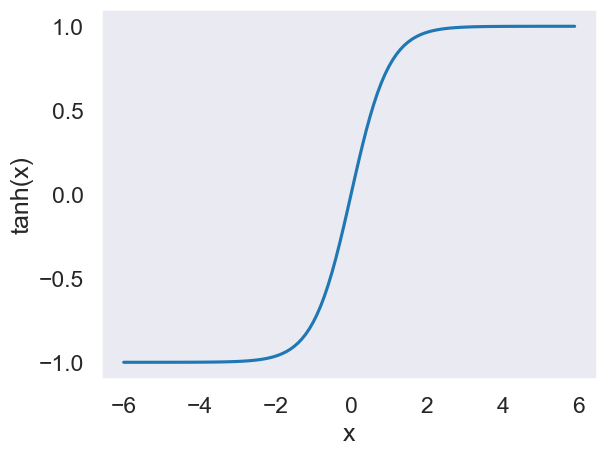

In [5]:
output_sigmoid = torch.nn.Sigmoid()(input)
sns.lineplot(x=input,y=output_sigmoid)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.show()
output_tanh = torch.nn.Tanh()(input)
sns.lineplot(x=input,y=output_tanh)
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.show()

In [30]:
from typing import List #just to help readability
def create_sequential_model(dim_in:int, dim_out:int, hidden_layer_sizes:List[int]):
  print(dim_in)
  hiddens = [dim_in, *hidden_layer_sizes]
  # print(hiddens)
  torch_layers = []
  #Create a linear layer and feed it through a ReLU
  for i in range(len(hiddens)-1):
    torch_layers.append(torch.nn.Linear(hiddens[i], hiddens[i+1]))
    torch_layers.append(torch.nn.ReLU())
    
  torch_layers.append(torch.nn.Linear(hiddens[-1], dim_out)) #create the output layer
  return torch.nn.Sequential(*torch_layers)

#### Loss function
The loss function we choose depends on the problem at hand. We could use cross-entropy with logits for classification, and we could use something like MSE for regression. These are the loss functions that we will start with in this prac.

There are many loss functions that we can use and as always no free lunch theorem holds. Some problems and models will perform better with certain loss functions.

Important: When evaluating your model it is important to look at both accuracy and loss, as loss can sometimes be misleading.

#### Optimisers
The most popular optimisers that are currently used with NNs are a family of stochastic gradient descent (SGD) optimisers. The stochastic part of SGD primarily means that we sample random batchs of size N from our dataset. This reduces bias but increases variance. This method has is necessary when dealing with large datasets as most computers do not have enough memory to load millions or billions of images at once.

SGD optimisers that we can use in torch include standard SGD, SGD with momentum, and fancier SGD variants with adaptive learning rates like ADAM, ADAGRAD, RMSPROP etc.

We can implement a simple SGD function ourselves.

The first thing we need to do to choose the loss function and optimiser is to pick a dataset

In [7]:
import torchvision

CIFAR10_train = torchvision.datasets.CIFAR10('CIFAR10_data',download=True,train=True, transform=True)
CIFAR10_validation = torchvision.datasets.CIFAR10('CIFAR10_data',download=True,train=False, transform=True)
print(CIFAR10_train.data.shape)
print(len(CIFAR10_train.classes))
training_data = (CIFAR10_train.data.reshape((-1,32*32*3))/255.0).astype(np.float32) # flatten the dataset and normalise
training_labels = np.asarray(CIFAR10_train.targets)
validation_data = (CIFAR10_validation.data.reshape((-1,32*32*3))/255.0).astype(np.float32) # flatten the dataset and normalise
validation_labels = np.asarray(CIFAR10_validation.targets)

100.0%


Extracting CIFAR10_data\cifar-10-python.tar.gz to CIFAR10_data
Files already downloaded and verified
(50000, 32, 32, 3)
10


We can see that the image is 32x32x3, this means that it is a dataset of 32x32 pixel RGB images. We will need to flatten to (50000,32x32x3) this for our model. It also has 10 classes so our model will have to have 10 outputs. We will start with one hidden layer with one hundred neurons.

In [31]:
model = create_sequential_model(32*32*3,10, [100,100])

3072
[3072, 100, 100]


Because this is a classification problem we can use cross entropy loss and sgd

In [26]:
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
learning_rate = 1e-3 #starting learning rate that we can tweak to increase performance
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate) #model.parameters gives the weight matrices and biases to the optimiser (AKA trainable parameters)

#### Training
To train our model we need to iterate applying gradient descent to the model w.r.t the loss. Overtime hopefully we will see accuracy increase and loss decrease.

In [27]:
batch_size = 256 #the number of datapoints per batch that we do
optimisation_steps = int(1e4) #the number of batches that we train on

metrics = []
for i in range(optimisation_steps):
  idx = np.random.randint(0, training_data.shape[0], size = batch_size) # random sample of batch_size indices from 0 to the number of datapoints the dataset has 
  x = training_data[idx,:] # get the datapoints at the sampled indices
  # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)).as # flatten the datapoints
  y_pred = model(torch.from_numpy(x)) # predict the classes of the datapoints)

  loss = criterion(y_pred,torch.from_numpy(training_labels[idx]).long()) # compute the loss by comparing the predicted labels vs the actual labels
 
  # zero the gradients held by the optimiser
  optimiser.zero_grad()

  # perform a backward pass to compute the gradients
  loss.backward()

  # update the weights
  optimiser.step()

  if i%100==99:
    if i%1000==999:
      train_pred =  model(torch.from_numpy(training_data))
      val_pred =  model(torch.from_numpy(validation_data))
      train_accuracy = torch.mean((train_pred.argmax(dim=1) == torch.from_numpy(training_labels)).float())
      val_accuracy = torch.mean((val_pred.argmax(dim=1) == torch.from_numpy(validation_labels)).float())
      # print the loss every 100 steps
      metrics.append([i,loss.item(),train_accuracy.numpy(), val_accuracy.numpy()])
    print(f'\rEpoch: {i} Loss:{round(loss.item(),2)}', end='')
    

Epoch: 9999 Loss:1.94

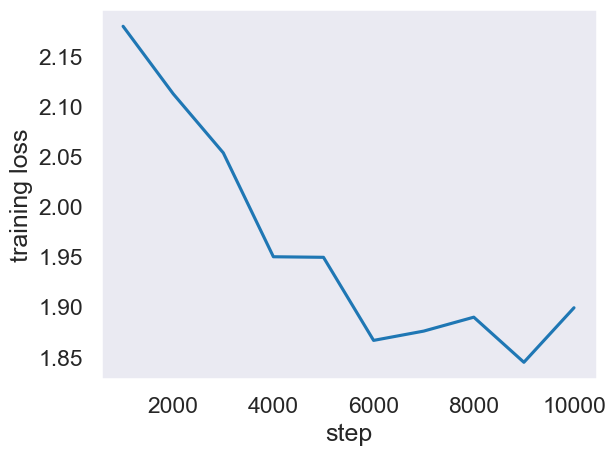

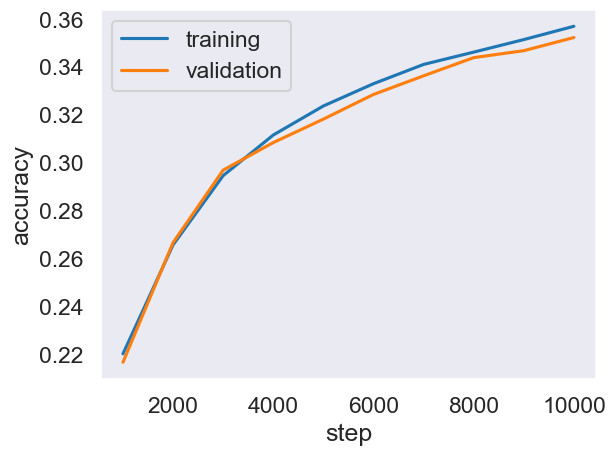

In [28]:
metrics = np.asarray(metrics)
sns.lineplot(x=metrics[:,0],y=metrics[:,1])
plt.xlabel('step')
plt.ylabel('training loss')
plt.show()
sns.lineplot(x=metrics[:,0],y=metrics[:,2],label='training')
sns.lineplot(x=metrics[:,0],y=metrics[:,3], label='validation')
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

## Q 2)
Take note of the performance (training, test and validation errors) that the network achieved.
Modify the network size to see how it affects performance.

In [33]:
##SETUP
def run_MLP():
    metrics = []
    for i in range(optimisation_steps):
        idx = np.random.randint(0, training_data.shape[0], size = batch_size) # random sample of batch_size indices from 0 to the number of datapoints the dataset has 
        x = training_data[idx,:] # get the datapoints at the sampled indices
        # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)).as # flatten the datapoints
        y_pred = model(torch.from_numpy(x)) # predict the classes of the datapoints)

        loss = criterion(y_pred,torch.from_numpy(training_labels[idx]).long()) # compute the loss by comparing the predicted labels vs the actual labels
        
        # zero the gradients held by the optimiser
        optimiser.zero_grad()

        # perform a backward pass to compute the gradients
        loss.backward()

        # update the weights
        optimiser.step()

        if i%100==99:
            if i%1000==999:
                train_pred =  model(torch.from_numpy(training_data))
                val_pred =  model(torch.from_numpy(validation_data))
                train_accuracy = torch.mean((train_pred.argmax(dim=1) == torch.from_numpy(training_labels)).float())
                val_accuracy = torch.mean((val_pred.argmax(dim=1) == torch.from_numpy(validation_labels)).float())
                # print the loss every 100 steps
                metrics.append([i,loss.item(),train_accuracy.numpy(), val_accuracy.numpy()])
            # print(f'\rEpoch: {i} Loss:{round(loss.item(),2)}', end='')
    return metrics
            

3072
[3072, 100]
Epoch: 9999 Loss:2.153072
[3072, 100]
Epoch: 9999 Loss:1.853072
[3072, 100]
Epoch: 9999 Loss:1.513072
[3072, 100, 100]
Epoch: 9999 Loss:2.283072
[3072, 100, 100]
Epoch: 9999 Loss:1.923072
[3072, 100, 100]
Epoch: 9999 Loss:1.713072
[3072, 100, 100, 100]
Epoch: 9999 Loss:2.33072
[3072, 100, 100, 100]
Epoch: 9999 Loss:2.013072
[3072, 100, 100, 100]
Epoch: 9999 Loss:1.743072
[3072, 100, 100, 100, 100]
Epoch: 9999 Loss:2.33072
[3072, 100, 100, 100, 100]
Epoch: 9999 Loss:2.253072
[3072, 100, 100, 100, 100]
Epoch: 9999 Loss:1.69

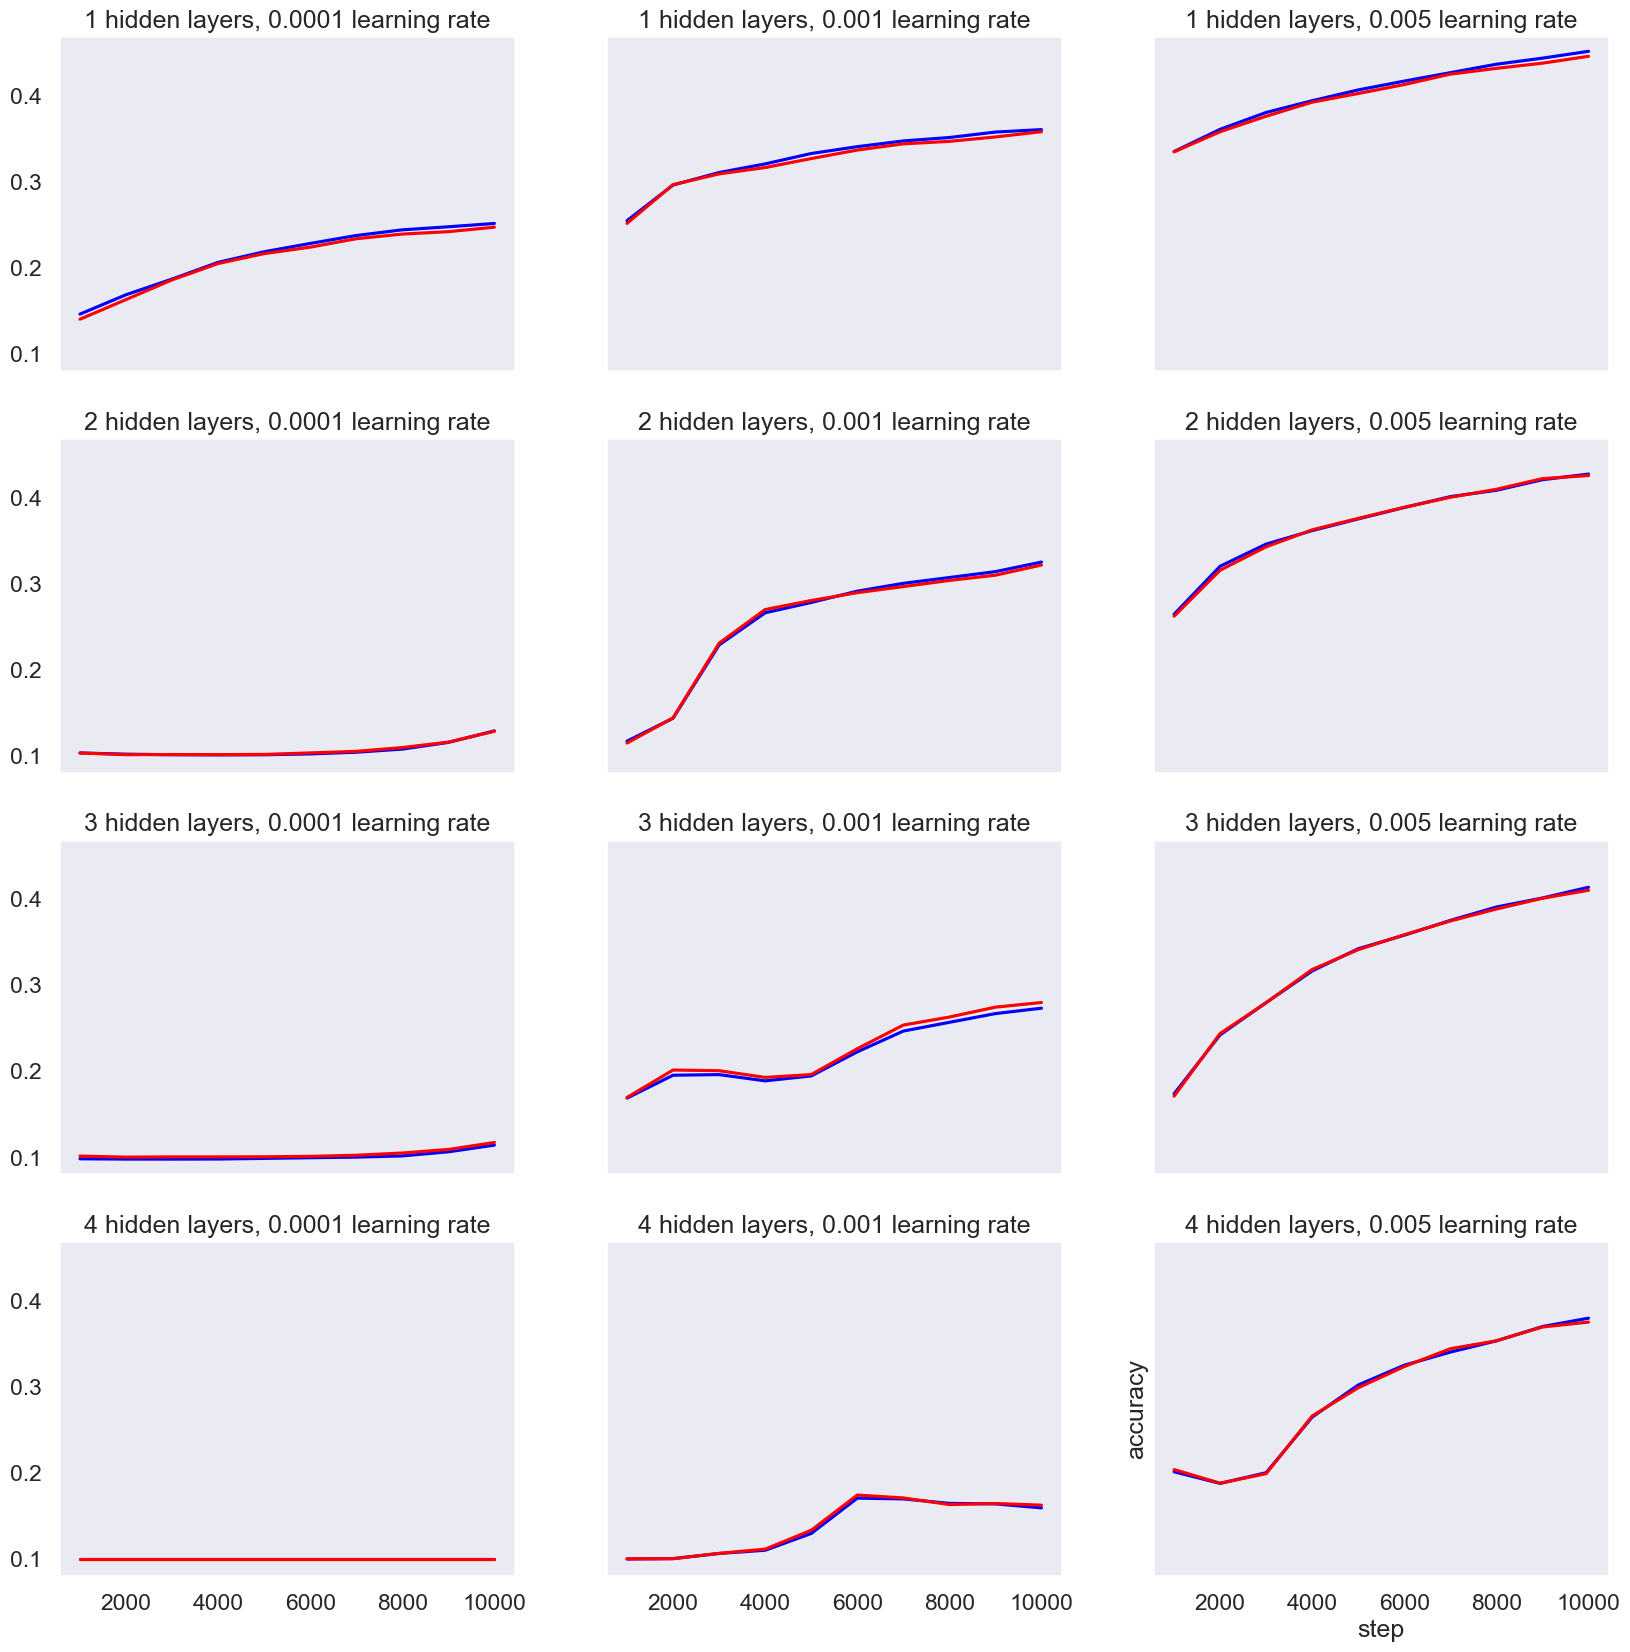

: 

In [36]:
hidden_layers = [1, 2, 3, 4]
learning_rate = [1e-4, 1e-3, 5e-3]
batch_size = 256 #the number of datapoints per batch that we do
optimisation_steps = int(1e4) #the number of batches that we train on

fig, axs = plt.subplots(nrows=len(hidden_layers), ncols=len(learning_rate), sharex=True, sharey=True)

fig.set_figwidth(20)
fig.set_figheight(20)

for row, i in enumerate(hidden_layers):
    for col, l in enumerate(learning_rate):
        model = create_sequential_model(32*32*3, 10, [100] * i)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        optimiser = torch.optim.SGD(model.parameters(), lr=l)
        metrics = run_MLP()

        metrics = np.asarray(metrics)
        axs[row, col].plot(metrics[:,0],metrics[:,2], color='blue', label='training')
        axs[row, col].plot(metrics[:,0], metrics[:,3], color='red', label='validation')
        axs[row, col].set_title(f'{i} hidden layers, {l} learning rate')
plt.xlabel('step')
plt.ylabel('accuracy')   
plt.show()
    